In [2]:
# 在import tensorflow之前
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np 
import glob
import cv2

# 前处理 

## 数据增强器

# 加载数据

In [8]:
image_names = glob.glob("brain_2d_seg_data/training/images/*.png")
image_names.sort()
image_names_subset = image_names[0:len(image_names)]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [9]:
print("Image data shape is: ", image_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())

Image data shape is:  (915, 160, 160, 1)
Max pixel value in image is:  255


In [10]:
#Normalize images
image_dataset = image_dataset /255.

In [11]:
X_train = image_dataset

### 看看加载的图片

用  `next()` 获取图片

In [12]:
from tensorflow.keras.utils import to_categorical

#n_classes = 3
#train_label = to_categorical(y_train, num_classes=n_classes)

In [13]:
# label 需要换一种加载方式 train_label
import glob
mask_names = glob.glob("brain_2d_seg_data/training/labels_np/*.png")
mask_names.sort()
print(mask_names)

['brain_2d_seg_data/training/labels_np\\0.png', 'brain_2d_seg_data/training/labels_np\\1.png', 'brain_2d_seg_data/training/labels_np\\10.png', 'brain_2d_seg_data/training/labels_np\\100.png', 'brain_2d_seg_data/training/labels_np\\101.png', 'brain_2d_seg_data/training/labels_np\\102.png', 'brain_2d_seg_data/training/labels_np\\103.png', 'brain_2d_seg_data/training/labels_np\\104.png', 'brain_2d_seg_data/training/labels_np\\105.png', 'brain_2d_seg_data/training/labels_np\\106.png', 'brain_2d_seg_data/training/labels_np\\107.png', 'brain_2d_seg_data/training/labels_np\\108.png', 'brain_2d_seg_data/training/labels_np\\109.png', 'brain_2d_seg_data/training/labels_np\\11.png', 'brain_2d_seg_data/training/labels_np\\110.png', 'brain_2d_seg_data/training/labels_np\\111.png', 'brain_2d_seg_data/training/labels_np\\112.png', 'brain_2d_seg_data/training/labels_np\\113.png', 'brain_2d_seg_data/training/labels_np\\114.png', 'brain_2d_seg_data/training/labels_np\\115.png', 'brain_2d_seg_data/traini

In [14]:
mask_names_subset = mask_names[0:len(mask_names)]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)

In [15]:
mask_dataset.shape

(915, 160, 160)

In [16]:
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1 2]


In [17]:
y_train= np.expand_dims(mask_dataset, axis = 3)

In [18]:
y_train.shape

(915, 160, 160, 1)

In [19]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=3)
############
#y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))#???????? 保留0，1，2的维度，最后一个设成类数


In [20]:
train_masks_cat.shape

(915, 160, 160, 3)

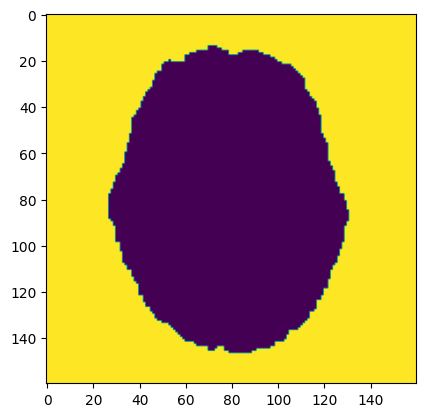

In [21]:
plt.imshow(train_masks_cat[0,:,:,0])

## Create our model 

Use:
- Max-pooling & up-convolutions
- 16 deep in first conv layer
- 2 convolutions in each stage
- 4 skip connections
- padding to get same size outputs


Set each layer to `x`, to make it easier to copy-paste and re-arrange things. 



In [22]:
img_shape = (160,160,1) ##################### 3 classes
input_layer = keras.layers.Input(img_shape)

x = keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu')(input_layer)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
out_layer1 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
out_layer2 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
out_layer3 = x
x = keras.layers.MaxPooling2D((2,2))(x)


x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
out_layer4 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(128,(2,2),padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer4,x])
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(64,(2,2),padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer3,x])
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(32,(2,2), padding='same',activation='relu')(x)


x = keras.layers.Concatenate(axis=3)([out_layer2,x])   # axis specifies along which axis the input will be concatenated
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(16,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer1,x])
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)

#1x1 conv????? with softmax to get 3-class classification at each pixel
x = keras.layers.Conv2D(3,(1,1), padding='same',activation='softmax')(x) ###############  need one hot

model = keras.Model(input_layer, x)

###  Compile and visualize it

In [23]:
"""
# Compile the model
optimizer = keras.optimizers.Adam()

#loss = ['binary_crossentropy',dice_loss]
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False) ## 有softmax flag=False

# metrics = ['binary_accuracy',dice_metric]
metrics = ['accuracy']

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics) 
"""
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# What does the finished model look like?
model.summary()
keras.utils.plot_model(model, show_shapes=True, rankdir='TD')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_22 (Conv2D)             (None, 160, 160, 3)  51          ['conv2d_21[0][0]']              
                                                                                                  
Total params: 1,940,851
Trainable params: 1,940,851
Non-trainable params: 0
__________________________________________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Fit the model

The fit() function takes x and y -- we want to pass the image and mask  correspondingly.

But since we are using generators, we need the output of the generator to be: `(image, mask)`

We can create this behaviour by using `zip()` to zip together the image and mask generators. 




In [24]:
# combine generators into one which yields both image and masks
# train_generator = zip(image_generator_train, train_masks_cat)


history = model.fit(X_train,
                    #train_generator,
                    train_masks_cat,
                    batch_size = 16,
                    steps_per_epoch=100,
                    epochs=10)

Epoch 1/10
100/100 [==============================] - 86s 854ms/step - loss: 0.3713 - accuracy: 0.8748
Epoch 2/10
100/100 [==============================] - 85s 855ms/step - loss: 0.1075 - accuracy: 0.9603
Epoch 3/10
100/100 [==============================] - 86s 857ms/step - loss: 0.0913 - accuracy: 0.9624
Epoch 4/10
100/100 [==============================] - 87s 865ms/step - loss: 0.0848 - accuracy: 0.9642
Epoch 5/10
100/100 [==============================] - 87s 871ms/step - loss: 0.0842 - accuracy: 0.9643
Epoch 6/10
100/100 [==============================] - 68s 682ms/step - loss: 0.0796 - accuracy: 0.9662


In [28]:
from tensorflow.keras.utils import to_categorical

In [29]:
y_train=zip(mask1_generator_train, mask2_generator_train)

In [31]:
y_train=mask1_generator_train
train_mask = to_categorical(y_train, num_classes=1)

KeyboardInterrupt: 

In [30]:
train_mask = to_categorical(y_train, num_classes=3)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'zip'

In [23]:
print(image_generator_train)

In [24]:
train_generator = zip(image_generator_train, mask1_generator_train, mask2_generator_train)

In [26]:
train_generator.shape

AttributeError: 'zip' object has no attribute 'shape'

In [21]:
# combine generators into one which yields both image and masks
train_generator = zip(image_generator_train, mask1_generator_train, mask2_generator_train)
test_generator = zip(image_generator_test, mask1_generator_test, mask2_generator_test)

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'model/conv2d/Relu' defined at (most recent call last):
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\ipykernel\zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ziyif\AppData\Local\Temp\ipykernel_14296\1625064823.py", line 5, in <module>
      history = model.fit(train_generator,
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\ziyif\miniconda3\envs\bilibili_env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d/Relu'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model/conv2d/Relu}}]] [Op:__inference_train_function_4989]

Plot the loss and metrics on training data

In [15]:
#plot loss and metrics
import pandas as pd
import seaborn as sns
df = pd.DataFrame(history.history)
sns.lineplot(data=df)


ModuleNotFoundError: No module named 'seaborn'

Evaluate the metrics on the test data

In [16]:
metrics = model.evaluate(test_generator,steps=197,return_dict=True)
print(metrics)

197/197 [==============================] - 6s 30ms/step - loss: 0.0221 - binary_accuracy: 0.9916 - dice_metric: 0.9788
{'loss': 0.022072266787290573, 'binary_accuracy': 0.9916053414344788, 'dice_metric': 0.9788303971290588}


Let's take a look at some results for the test dataset

1/1 [==============================] - 0s 40ms/step


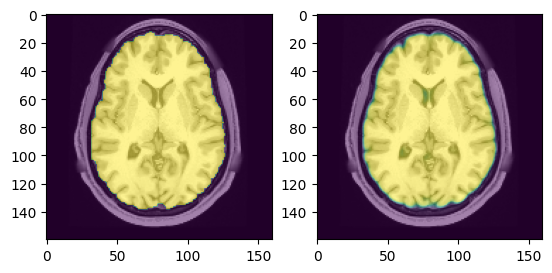

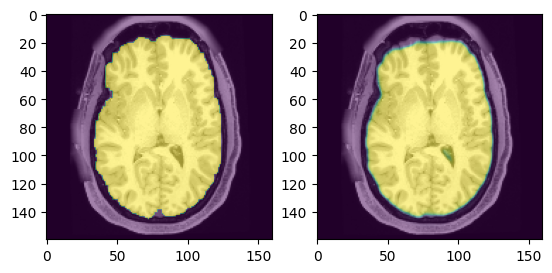

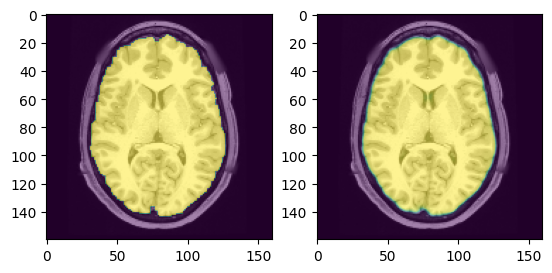

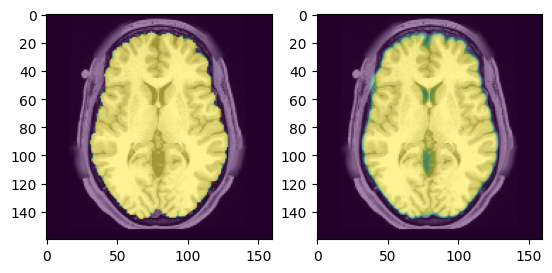

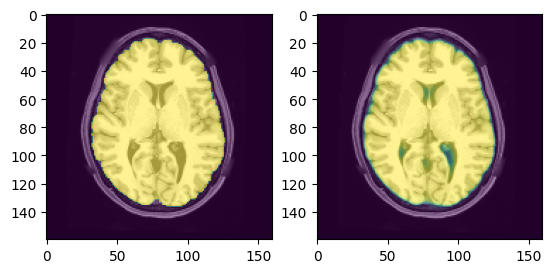

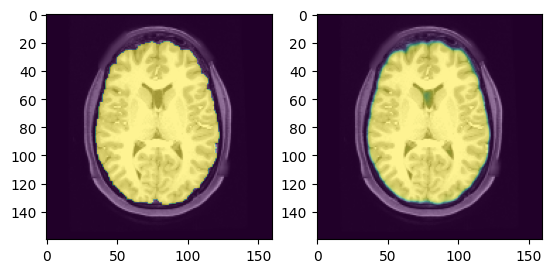

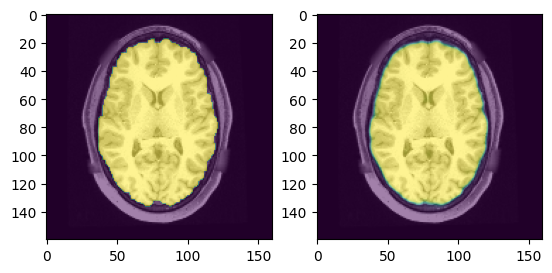

In [17]:
#plot some examples from the test set

for sample,(image,mask) in enumerate(test_generator):
  
  predicted = model.predict(image)

  plt.figure()

  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(mask),alpha=0.5)
  
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(predicted),alpha=0.5)
  

  if sample > 5:
    break
  

## Now what?

- Try segmenting the ventricles with this configuration

- Try using a custom loss function



## Beyond this example

### More than just binary labels?

We took a shortcut here and used a single channel output and sigmoid to get our label. More generally if you have multiple labels, you will want to use a *one-hot* encoding analogous to what we did for multi-class classification, and use a soft-max activation.

 E.g. if we wanted to have our example data (brain and ventricle segmentation) set up in this way, we would need to have the following 3 channels:
 - background: 1 where neither brain nor ventricles are, 0 elsewhere
 - brain: 1 where brain is, 0 elsewhere (we have this already)
 - ventricles: 1 where ventricles are, 0 elsewhere (we have this already)

So in this case you would need to create the background channel, e.g. via logical operations on the other channels. 

If you are starting with a single image with multiple labels on it, then you should be able to use Keras' built-in `to_categorical()` to achieve this.

Note that if you have multiple labels, you would also need to account for this in any custom loss functions you create.

### Validation split?
We didn't use a validation split here for the sake of simplicity. You can achieve this by either putting your validation data in another directory and creating another `flow` generator, **or** you can use `validation_split` in the ImageDataGenerator, then specify `subset='validation'` or `subset='training'` in your `flow` generator to make use of the reserved split. 

In both cases you would need to then pass the validation generator to the `fit()` functions `validation_data` parameter. 


### U-net example from original paper

An implementation of this is also posted, and shows how you would need to perform cropping of the segmentation, and also uses the soft-max for binary segmentation. Please have a look to further your understanding.